In [436]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# This should allow us to plot residuals, to confirm our models aren't missing any vital components
from yellowbrick.regressor import ResidualsPlot

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [437]:
def quick_boxplot(series,title,**kwargs):
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [438]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [439]:
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [440]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Data cleaning, feature building

In [441]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [442]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Which variables are categorical? Let's blow them out into one-hot dummy variables.

In [443]:
for categorical in house_df.describe(exclude=np.number).columns:
    house_df = pd.concat([house_df, pd.get_dummies(house_df[categorical],drop_first=True,prefix=categorical)], axis=1)

__Transformations and features!__

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

Some of the dataframe columns can be summarized with a single dummy feature, indicating whether or not a house has a particular feature.

In [444]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [445]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})
house_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))
house_df['last_remodeled'] = 2019 - house_df['yearremodadd']

Figure out which variables are the most highly correlated to saleprice--we can start with this list, and whittle it down by following the guidelines for meeting the assumptions of linear regression.

In [446]:
overall_correlation = house_df.corr()

In [447]:
correlated_columns = overall_correlation['saleprice'].sort_values(ascending=False).head(20).index

In [448]:
corr_col_corr = house_df[correlated_columns].corr()

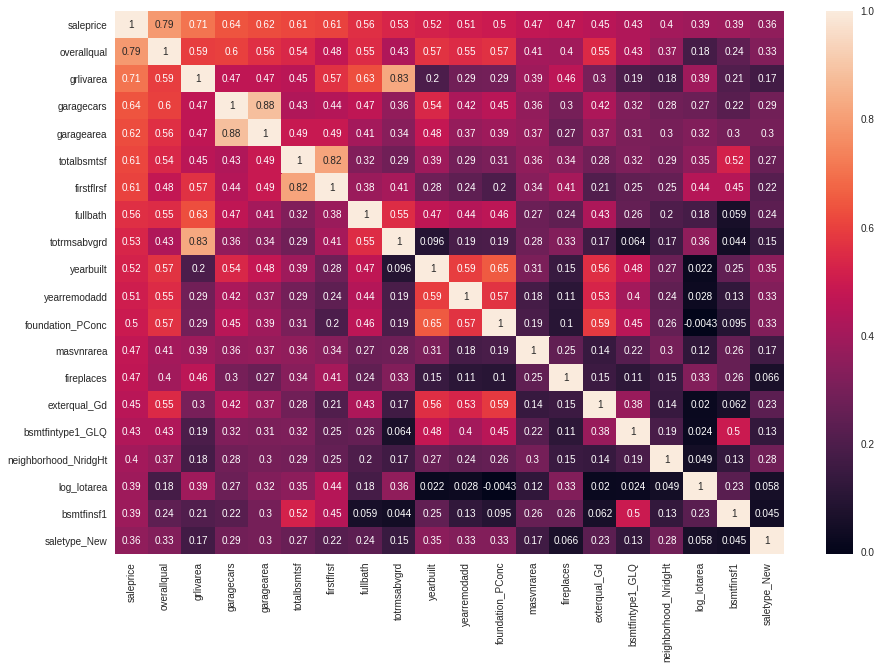

In [449]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(corr_col_corr,annot=True)

__Reducing the list of features:__
* overallqual is highly correlated to too many of the other features. I don't want to use it.
* garagecars and garagearea are highly correlated. Use just garagecars.
* totrmsabvgrd is too close to grlivarea, so don't use it.
* firstflsf and totalbsmtsf are highly correlated. Drop firstflsf.
* bsmtfinsf1 is close to totalbsmtsf. Drop it.

__Start with this list:__
* grlivarea
* garagecars
* totalbsmtsf
* fullbath
* yearbuilt
* yearremodadd
* foundation_PConc
* masvnrarea
* fireplaces
* exterqual_Gd
* bsmtfintype1_GLQ
* neighborhood_NridgHt
* log_lotarea
* saletype_New

We will probably further reduce this list after seeing how significant these features are (or rather, aren't).

In [450]:
# Start with these features of interest. 
# I commented out the features that turned out to be insignificant, so you can see which ones were dropped.
vars_of_interest = ['grlivarea', 'garagecars', 'totalbsmtsf', 'yearbuilt', #'yearremodadd',
                    'exterqual_Gd', 'fireplaces', 'bsmtfintype1_GLQ', #'masvnrarea', 'foundation_PConc', 
                    'log_lotarea', 'neighborhood_NridgHt',  #'bsmtfinsf1', 'fullbath', 'saletype_New', 
                   ]

import copy
int_plus_saleprice = copy.deepcopy(vars_of_interest)
int_plus_saleprice.append('saleprice')

# Create a copy of the dataframe that's just these variables--it'll be easier to manage/manipulate
house_interest_df = house_df[int_plus_saleprice]
house_interest_df.head()

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
0,1710,2,856,2003,1,0,1,9.041922,0,208500
1,1262,2,1262,1976,0,1,0,9.169518,0,181500
2,1786,2,920,2001,1,1,1,9.328123,0,223500
3,1717,3,756,1915,0,1,0,9.164296,0,140000
4,2198,3,1145,2000,1,1,1,9.565214,0,250000


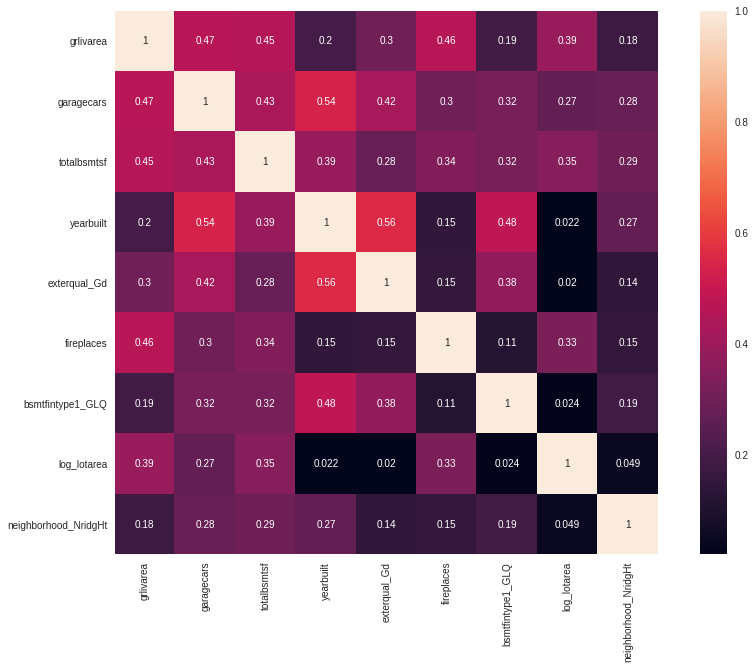

In [451]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(house_interest_df[vars_of_interest].corr(),annot=True,square=True)

## Reimplement your model from the previous checkpoint.

__NOTE:__ Performing a log transformation on the dependent variable (home sale price) made its distribution much more normal, and made the model fit better.

In [452]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[vars_of_interest]

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [454]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     505.9
Date:                Mon, 05 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:50:01   Log-Likelihood:                 353.70
No. Observations:                1168   AIC:                            -687.4
Df Residuals:                    1158   BIC:                            -636.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.4459      0.504      8.816      0.000       3.456       5.435
grlivarea                0.0003   1.32e-05     20.141      0.000       0.000       0.000
garagecars               0.0984      0.010     10.203      0.000       0.079       0.117
totalbsmtsf           8.573e-05   1.49e-05      5.739      0.000    5.64e-05       0.000
yearbuilt                0.0030      0.000     12.084      0.000       0.003       0.003
exterqual_Gd             0.0846      0.014      6.015      0.000       0.057       0.112
fireplaces               0.0772      0.009      8.226      0.000       0.059       0.096
bsmtfintype1_GLQ         0.0847      0.014      6.199      0.000       0.058       0.111
log_lotarea              0.0953      0.012      8.174      0.000       0.072       0.118
neighborhood_NridgHt     0.1579      0.024      6.465      0.000       0.110       0.206
==============================================================================
Omnibus:                      731.460   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21805.221
Skew:                          -2.383   Prob(JB):                         0.00
Kurtosis:                      23.624   Cond. No.                     2.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

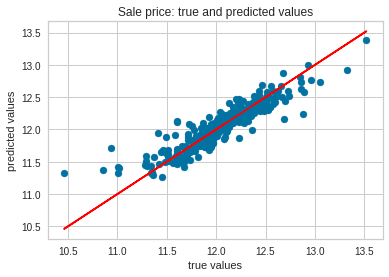

Mean absolute error of the prediction is: 0.12037581143793097
Mean squared error of the prediction is: 0.029014012716681564
Root mean squared error of the prediction is: 0.17033500144327812
Mean absolute percentage error of the prediction is: 1.008449224254358


In [455]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Which model is the best? Why?

In [456]:
model = LinearRegression()
print(str(model))
#print(model.__str__)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [457]:
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

In [458]:
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print(ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [459]:
# I learned that the estimator object (first parameter) needs to be from the sklearn module--
# I can't use sm.OLS. :)

kfold_xval(LinearRegression(),X,Y)

Cross-validation using 10 folds
[0.81957809 0.85012414 0.8519278  0.75116459 0.82530735 0.82102813
 0.81022536 0.80425533 0.50565253 0.8504114 ]


In [460]:
linear = LinearRegression() 
linear.fit(X_train, y_train)

# We are making predictions here
y_preds_train = linear.predict(X_train)
y_preds_test = linear.predict(X_test)

print("R-squared of the model on the training set is: {}".format(linear.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(linear.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7972398104285067
-----Test set statistics-----
R-squared of the model on the test set is: 0.8260007119308203
Mean absolute error of the prediction is: 0.120375811437936
Mean squared error of the prediction is: 0.029014012716683413
Root mean squared error of the prediction is: 0.17033500144328356
Mean absolute percentage error of the prediction is: 1.0084492242543965


These results look _terrible_, or I thought they did. My understanding was that if the folds don't report very similar scores, that your model is probably overfitting. I tried a few different ways to confirm/correct this. 

First up, I tried normalizing the variables I had, to see if I could identify the most significant ones based on their coefficients, and remove less significant variables that may only be contributing to overfitting. I can't say this was the best method ever, but it was good to know this is a possibility.

In [461]:
def normalize(df,**kwargs):
    convert_cols = kwargs.get('convert_cols',df.columns)
    result = df.copy(deep=True)
    for feature_name in convert_cols:
        try:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        except TypeError:
            print("Skipping non-numerical column {}".format(feature_name))
    return result

In [462]:
small_house_interest_df = normalize(house_interest_df)

In [463]:
small_house_interest_df

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
0,0.259231,0.50,0.140098,0.949275,1.0,0.000000,1.0,0.366344,0.0,0.241078
1,0.174830,0.50,0.206547,0.753623,0.0,0.333333,0.0,0.391317,0.0,0.203583
2,0.273549,0.50,0.150573,0.934783,1.0,0.333333,1.0,0.422359,0.0,0.261908
3,0.260550,0.75,0.123732,0.311594,0.0,0.333333,0.0,0.390295,0.0,0.145952
4,0.351168,0.75,0.187398,0.927536,1.0,0.333333,1.0,0.468761,0.0,0.298709
5,0.193670,0.50,0.130278,0.876812,0.0,0.000000,1.0,0.466761,0.0,0.150118
6,0.256217,0.50,0.275941,0.956522,1.0,0.333333,1.0,0.400943,0.0,0.377864
7,0.330821,0.50,0.181178,0.731884,0.0,0.666667,0.0,0.406643,0.0,0.229274
8,0.271289,0.50,0.155810,0.427536,0.0,0.666667,0.0,0.303205,0.0,0.131926
9,0.139977,0.25,0.162193,0.485507,0.0,0.666667,1.0,0.340903,0.0,0.115401


In [464]:
# Y is the target variable
Y = np.log(small_house_interest_df['saleprice'])

# X is the feature set.
X = small_house_interest_df[vars_of_interest]

And of course now that I've had to rerun this notebook a few times, my original work has been lost to the ages. But once I had normalized all of the numerical features, I ran the following cell, looked at the coefficients of the features, then started removing the ones with the smallest coefficients, rerunning after each removal to see what changed.

In [465]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     505.9
Date:                Mon, 05 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:50:01   Log-Likelihood:                 353.70
No. Observations:                1168   AIC:                            -687.4
Df Residuals:                    1158   BIC:                            -636.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.4459      0.504      8.816      0.000       3.456       5.435
grlivarea                0.0003   1.32e-05     20.141      0.000       0.000       0.000
garagecars               0.0984      0.010     10.203      0.000       0.079       0.117
totalbsmtsf           8.573e-05   1.49e-05      5.739      0.000    5.64e-05       0.000
yearbuilt                0.0030      0.000     12.084      0.000       0.003       0.003
exterqual_Gd             0.0846      0.014      6.015      0.000       0.057       0.112
fireplaces               0.0772      0.009      8.226      0.000       0.059       0.096
bsmtfintype1_GLQ         0.0847      0.014      6.199      0.000       0.058       0.111
log_lotarea              0.0953      0.012      8.174      0.000       0.072       0.118
neighborhood_NridgHt     0.1579      0.024      6.465      0.000       0.110       0.206
==============================================================================
Omnibus:                      731.460   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21805.221
Skew:                          -2.383   Prob(JB):                         0.00
Kurtosis:                      23.624   Cond. No.                     2.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next up: when I reached out on Slack, one of the technical coaches suggested I take a look at the Huber Regressor model, which mitigates the effect of outliers (explanation [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html#sphx-glr-auto-examples-linear-model-plot-huber-vs-ridge-py)).

I don't think this gave me results that were any better than the basic linear regression model, even after playing with a variety of values for epsilon >= 1. (1.35 is the default, but I define it explicitly to show how/where to plug in non-default values.)

In [466]:
from sklearn.linear_model import HuberRegressor
kfold_xval(HuberRegressor(epsilon=1.35),X_train,y_train)

Cross-validation using 10 folds
[0.61657608 0.83079172 0.85283142 0.80482891 0.83244737 0.78663647
 0.46106387 0.86568814 0.80534927 0.81692752]


The last suggestion from a different technical coach was to plot the residuals. I hadn't heard this one before, but it might be the best diagnostic tool for linear regression that I learned about so far. If there is a pattern to the residuals, that means the model is missing features that may explain the pattern. If the residuals seem more or less random, but are normally distributed, you're probably fine.

Based on this plot, I think my model is fine. With the exception of some small and extremely large outliers, the residuals are both random and normally distributed, in a fairly tight distribution. This is encouraging!

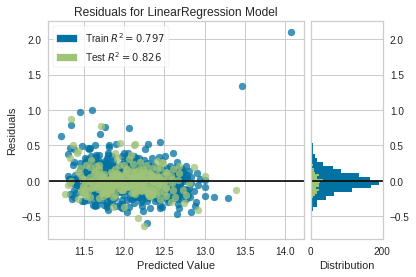

<Figure size 1080x576 with 0 Axes>

In [467]:
# Instantiate the linear model and visualizer
my_lr = LinearRegression()
visualizer = ResidualsPlot(my_lr)

fig=plt.figure(figsize=(15,8))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

I am also now reading ["A Gentle Introduction to k-fold Cross-Validation"](https://machinelearningmastery.com/k-fold-cross-validation/), which suggests setting k to different values, based on the available test data. Spread too thin, the folds may produce inconsistent results. The example for this concept is a sample size of 6, so I'm guessing that when we can split the data 10 ways (for instance) and have > 100 samples per fold, this is probably less of an issue.

Just for fun though, here are the scores generated when I set k to something besides the default of 10 that I defined:

In [468]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[vars_of_interest]

In [469]:
# Double k to 20
kfold_xval(LinearRegression(),X,Y,num_folds=20)

Cross-validation using 20 folds
[0.81376158 0.82239609 0.84206032 0.85932256 0.8562956  0.83946238
 0.82182943 0.65850198 0.83801913 0.81529255 0.87433143 0.76453026
 0.79021152 0.83079729 0.79750077 0.81137099 0.82414017 0.08657109
 0.86269089 0.83195883]


20 folds gives us results that are all high 70%s and low-mid 80%s, with one fold at 65.9%.

In [470]:
# Halve k to 5
cv_results = kfold_xval(LinearRegression(),X,Y,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.8362928425358016, 'Fold_2': 0.8030433689159264, 'Fold_3': 0.8209474532608487, 'Fold_4': 0.8055907045696301, 'Fold_5': 0.6941383564813395}


Setting k to 5 gives us results that are all in the low 80%s, with one exception fold that is only 69.4%. This makes comparisons a little easier, so let's run the rest of the regression models with k=5.

__Moving on, here is Ridge:__

In [471]:
from sklearn.linear_model import Ridge
cv_results = kfold_xval(Ridge(),X_train,y_train,num_folds=5)

kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.775029021735308, 'Fold_2': 0.8140968770550583, 'Fold_3': 0.8178710049442444, 'Fold_4': 0.7055857550180011, 'Fold_5': 0.8182132581123359}


These $R^2$ values seem terrible, but the lesson material suggests this may be okay? How does this look with the full test set?

In [472]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge() 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7972366912577226
-----Test set statistics-----
R-squared of the model on the test set is: 0.8260982759514389
Mean absolute error of the prediction is: 0.12030918277999314
Mean squared error of the prediction is: 0.028997744122907395
Root mean squared error of the prediction is: 0.1702872400472431
Mean absolute percentage error of the prediction is: 1.0078854836083573


__LASSO:__

Again, just manually increasing the exponent, `alpha=11**2` seems to offer consistent results across folds.

In [473]:
from sklearn.linear_model import Lasso
cv_results = kfold_xval(Lasso(),X_train,y_train,num_folds=5)

kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.6736278188291691, 'Fold_2': 0.7838258108420155, 'Fold_3': 0.7705377682632474, 'Fold_4': 0.534508036644374, 'Fold_5': 0.7295403870249628}


In [474]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
lassoregr = Lasso() 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7972366912577226
-----Test set statistics-----
R-squared of the model on the test set is: 0.8260982759514389
Mean absolute error of the prediction is: 0.1350378225656484
Mean squared error of the prediction is: 0.036360955838564454
Root mean squared error of the prediction is: 0.19068548932355722
Mean absolute percentage error of the prediction is: 1.1267901810816174


__ElasticNet:__

In [475]:
from sklearn.linear_model import ElasticNet

cv_results = kfold_xval(ElasticNet(),X_train,y_train,num_folds=5)

kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.6768527623815332, 'Fold_2': 0.7866421903874521, 'Fold_3': 0.776025223244647, 'Fold_4': 0.5492596193215352, 'Fold_5': 0.7339753809740072}


In [476]:
elasticregr = ElasticNet(alpha=12**2, l1_ratio=.8) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.17583043713418423
-----Test set statistics-----
R-squared of the model on the test set is: 0.17987368085913702
Mean absolute error of the prediction is: 0.2843511584289846
Mean squared error of the prediction is: 0.13675432650838862
Root mean squared error of the prediction is: 0.36980309153438484
Mean absolute percentage error of the prediction is: 2.3661965564943115


## Which model is the best performer?

In terms of average score from our 5-fold cross-validation tests, the best is, oddly, the Linear Regression model, followed by the Ridge model. The ElasticNet model scored only slightly better than the Lasso model, which rounds out the list.

In [477]:
kfold_df['avg_score'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_score'],ascending=False)

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_score
0,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",0.836293,0.803043,0.820947,0.805591,0.694138,0.792003
1,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",0.775029,0.814097,0.817871,0.705586,0.818213,0.786159
3,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",0.676853,0.786642,0.776025,0.549260,0.733975,0.704551
2,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",0.673628,0.783826,0.770538,0.534508,0.729540,0.698408



None of the coefficients for my models were especially large, so I'm wondering now if the mitigating effects the Ridge, Lasso, and ElasticNet models have on coefficients ended up hurting their predictive power...?

* Ridge is supposed to penalize large coefficients, when there really aren't any in this model.
* Lasso is supposed to shrink small coefficients to zero, effectively eliminating them from the model. It probably eliminated quite a bit--maybe too much and that's what ultimately hindered its accuracy?
* ElasticNet is a combination of these, allowing us to balance between the two. Since the circumstances here didn't benefit either of the other two models, maybe it is no surprise that this model didn't perform as well either...?

### Prediction stats for each model

The cross-validation scores made it easy to pick out the best model--the prediction stats are a lot closer. Linear regression still comes out on top, but barely. Ridge and Lasso's stats are mostly identical, with Ridge slightly outperforming Lasso. ElasticNet once again comes in last, and it's so far off that I probably want to double check and make sure I fed it the same training/test data.

```
__LinearRegression__
R-squared of the model on the training set is: 0.7972398104285067
-----Test set statistics-----
R-squared of the model on the test set is: 0.8260007119308203
Mean absolute error of the prediction is: 0.120375811437936
Mean squared error of the prediction is: 0.029014012716683413
Root mean squared error of the prediction is: 0.17033500144328356
Mean absolute percentage error of the prediction is: 1.0084492242543965

__Ridge__
R-squared of the model on the training set is: 0.7972366912577226
-----Test set statistics-----
R-squared of the model on the test set is: 0.8260982759514389
Mean absolute error of the prediction is: 0.12030918277999314
Mean squared error of the prediction is: 0.028997744122907395
Root mean squared error of the prediction is: 0.1702872400472431
Mean absolute percentage error of the prediction is: 1.0078854836083573

__Lasso__
R-squared of the model on the training set is: 0.7972366912577226
-----Test set statistics-----
R-squared of the model on the test set is: 0.8260982759514389
Mean absolute error of the prediction is: 0.1350378225656484
Mean squared error of the prediction is: 0.036360955838564454
Root mean squared error of the prediction is: 0.19068548932355722
Mean absolute percentage error of the prediction is: 1.1267901810816174

__ElasticNet__
R-squared of the model on the training set is: 0.17583043713418423
-----Test set statistics-----
R-squared of the model on the test set is: 0.17987368085913702
Mean absolute error of the prediction is: 0.2843511584289846
Mean squared error of the prediction is: 0.13675432650838862
Root mean squared error of the prediction is: 0.36980309153438484
Mean absolute percentage error of the prediction is: 2.3661965564943115
```

### Extra credit(?): Purposefully feeding the Lasso model a large number of parameters to see if it can make sense of them

In [478]:
house_df_no_price = house_df.copy(deep=True)
house_df_no_price.drop(columns='saleprice',inplace=True)

In [479]:
numerical_cols = house_df_no_price.describe(include=np.number).columns
#numerical_cols

In [480]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice']) #.values.reshape(-1,1))

# X is the feature set.
X = house_df_no_price[numerical_cols]

In [481]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [482]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
lassoregr = Lasso() 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


ValueError: shapes (1168,344) and (10,) not aligned: 344 (dim 1) != 10 (dim 0)